The notebook creates a single 1D extracted spectrum (x1d product) with continuous wavelength coverage from  an observation with SLIT = "S200A1 and S200A2" in APT. Use this workaround until this product is available by default in the MAST archive.

In [1]:
import json
import requests
from matplotlib import pyplot as plt
from pathlib import Path

from astropy.io import fits

Define function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {get_mast_api_token()}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create list of filenames. Download data from MAST.

In [3]:
names = []
for activity in [2, 4]:
    for exposure in [1, 2]:
        for detector in [1, 2]:
            names.append(f'jw02288003001_041{activity:02}_{exposure:05}_nrs{detector}_cal.fits')
for name in names:
    print(f'Downloading {name}')
    get_jwst_file(name)

Update SCI extension headers, so that SOURCEID=1 for spectra of the science target and SOURCEID has different values for spectra of other patches of sky. This compensates for default source numbering that is confusing.

Context: Each cal product includes a 'SCI' extension for each NIRSpec fixed slit that projects to the subarray in use. NIRSpec has five fixed slits, listed in the slitnum dictionary below.

In [4]:
slitnum = {'S200A1': 1, 'S200A2': 2, 'S400A1': 3, 'S1600A1': 4, 'S200B1': 5}
for name in names:
    with fits.open(name, 'update') as hdulist:
        fxd_slit = hdulist[0].header['fxd_slit']
        grating = hdulist[0].header['grating']
        print(f'{name}, grating={grating}')
        print(f'  target in {fxd_slit:7} (slitnum={slitnum[fxd_slit]})')
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'SCI':
                sltname = hdu.header['sltname']
                sourceid = hdu.header['sourceid']
                if sltname == fxd_slit:
                    newid = 1
                else:
                    newid = 10 * slitnum[fxd_slit] + slitnum[sltname]
                print(
                    f'  source in {sltname:7} (slitnum={slitnum[sltname]}), '
                    f'sourceid: {sourceid:02} -> {newid:02}')
                hdu.header['sourceid'] = newid


jw02288003001_04102_00001_nrs1_cal.fits, grating=G140H
  target in S200A1  (slitnum=1)
  source in S200A1  (slitnum=1), sourceid: 01 -> 01
  source in S200A2  (slitnum=2), sourceid: 02 -> 12
  source in S400A1  (slitnum=3), sourceid: 03 -> 13
  source in S1600A1 (slitnum=4), sourceid: 04 -> 14
jw02288003001_04102_00001_nrs2_cal.fits, grating=G140H
  target in S200A1  (slitnum=1)
  source in S200A1  (slitnum=1), sourceid: 01 -> 01
  source in S200A2  (slitnum=2), sourceid: 02 -> 12
  source in S400A1  (slitnum=3), sourceid: 03 -> 13
  source in S1600A1 (slitnum=4), sourceid: 04 -> 14
  source in S200B1  (slitnum=5), sourceid: 05 -> 15
jw02288003001_04102_00002_nrs1_cal.fits, grating=G140H
  target in S200A1  (slitnum=1)
  source in S200A1  (slitnum=1), sourceid: 01 -> 01
  source in S200A2  (slitnum=2), sourceid: 02 -> 12
  source in S400A1  (slitnum=3), sourceid: 03 -> 13
  source in S1600A1 (slitnum=4), sourceid: 04 -> 14
jw02288003001_04102_00002_nrs2_cal.fits, grating=G140H
  target

Download an association file (json) for one of the two slits.

In [5]:
pool_version = '20230527t003136'
orig_json_name = f'jw02288-o003_{pool_version}_spec3_00001_asn.json'
print(f'Downloading {orig_json_name}')
get_jwst_file(orig_json_name)

Dump contents of the original association file.

In [6]:
!cat $orig_json_name

{
    "asn_type": "spec3",
    "asn_rule": "candidate_Asn_Lv3NRSFSS",
    "version_id": "20230527t003136",
    "code_version": "1.10.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "02288",
    "constraints": "DMSAttrConstraint({'name': 'program', 'sources': ['program'], 'value': '2288'})\nDMSAttrConstraint({'name': 'instrument', 'sources': ['instrume'], 'value': 'nirspec'})\nDMSAttrConstraint({'name': 'exp_type', 'sources': ['exp_type'], 'value': 'nrs_autoflat|nrs_autowave|nrs_fixedslit'})\nDMSAttrConstraint({'name': 'opt_elem', 'sources': ['filter'], 'value': 'f170lp'})\nDMSAttrConstraint({'name': 'opt_elem2', 'sources': ['grating'], 'value': 'g235h'})\nDMSAttrConstraint({'name': 'opt_elem3', 'sources': ['fxd_slit'], 'value': 's200a1'})\nDMSAttrConstraint({'name': 'subarray', 'sources': ['subarray'], 'value': 'full'})\nConstraint_Target({'name': 'target', 'sources': ['targetid'], 'value': '2'})\nConstraint_Obsnum({'name': 'obs_num', 'sources':

Read original association file into json object.

In [7]:
with open(orig_json_name) as fobj:
    asn_data = json.load(fobj)

Update association data.

In [8]:
grating = 'g140h'
asn_data['products'][0]['name'] = grating
old_member = asn_data['products'][0]['members'][0]
members = []
for name in names:
    new_member = old_member.copy()
    new_member['expname'] = name
    members.append(new_member)
asn_data['products'][0]['members'] = members

Save updated association data to json file.

In [9]:
new_json_name = f'{grating}_asn.json'
with open(new_json_name, 'w') as fobj:
    json.dump(asn_data, fobj, indent=4)

Dump contents of the new association file.

In [10]:
!cat $new_json_name

{
    "asn_type": "spec3",
    "asn_rule": "candidate_Asn_Lv3NRSFSS",
    "version_id": "20230527t003136",
    "code_version": "1.10.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "02288",
    "constraints": "DMSAttrConstraint({'name': 'program', 'sources': ['program'], 'value': '2288'})\nDMSAttrConstraint({'name': 'instrument', 'sources': ['instrume'], 'value': 'nirspec'})\nDMSAttrConstraint({'name': 'exp_type', 'sources': ['exp_type'], 'value': 'nrs_autoflat|nrs_autowave|nrs_fixedslit'})\nDMSAttrConstraint({'name': 'opt_elem', 'sources': ['filter'], 'value': 'f170lp'})\nDMSAttrConstraint({'name': 'opt_elem2', 'sources': ['grating'], 'value': 'g235h'})\nDMSAttrConstraint({'name': 'opt_elem3', 'sources': ['fxd_slit'], 'value': 's200a1'})\nDMSAttrConstraint({'name': 'subarray', 'sources': ['subarray'], 'value': 'full'})\nConstraint_Target({'name': 'target', 'sources': ['targetid'], 'value': '2'})\nConstraint_Obsnum({'name': 'obs_num', 'sources':

[Install](https://jwst-pipeline.readthedocs.io/en/stable/) the jwst pipeline, for example into a conda environment. Activate the environment. [Configure](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html#crds) CRDS nvironment variables. [Run](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html#running-from-the-command-line) the calwebb_spec3 pipeline from the command line.
```
$ conda activate jwst
(jwst) $ export CRDS_CONTEXT='jwst_1068.pmap'
(jwst) $ strun calwebb_spec3 g140h_asn.json
```
Run this step outside the notebook before continuing.

New products will be generated for each SOURCEID specified above, but SOURCEID=1 is the science target.
List newly generated products for the science target.

In [11]:
for path in sorted(Path('.').glob('g140h_s00001_???.fits')):
    print(path.name)

g140h_s00001_cal.fits
g140h_s00001_crf.fits
g140h_s00001_s2d.fits
g140h_s00001_x1d.fits


Plot 1D extracted spectrum.

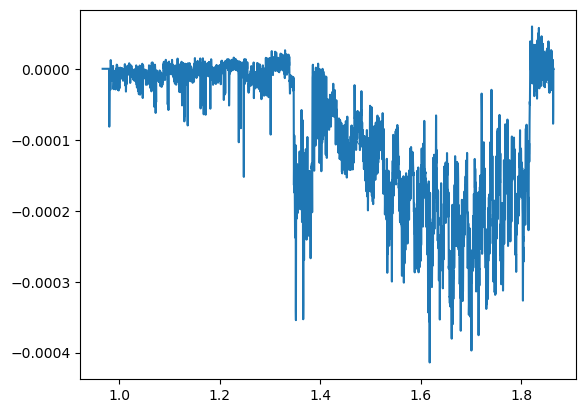

In [12]:
with fits.open('g140h_s00001_x1d.fits') as hdulist:
    data = hdulist['extract1d'].data
line2d = plt.plot(data['wavelength'], data['flux'])